# Finding the root of an equation

This section describes how to numerically find the root of an equation, i.e. the problem can be stated as: Find 
$x\in[a,b]$ such that

$$
f(x) = 0
\tag{1}
$$

where $f(x)\in C^1[a,b]$. 

Why is important? In a more general setting, determining the root is essential in many numerical methods. For instance, in the partial differential equation that governs Stokes flow
$$
\nabla\cdot\sigma + \rho g = 0
$$
the unknown stress $\sigma$ can be seen, in a slightly more abstract sense, as the root of a functional $\mathcal{F}(\sigma) = 0$.

Here we will restrict ourselves to the more basic scenario presented in eq. (1).

## Fixed point iteration method

Let's specify a function that we want to find the root of:
$$
f(x) = e^x - 2x - 1\tag{2}
$$

To get a good intuition of how the equation looks, and where the root(s?) could be, one could start by simply plotting the function $f(x)$.

Python, unlike MATLAB, is a general purpose high-level programming language; while it comes with a lot of glitz included in the standard library, things like plotting and numerical/matrix-oriented calculations are done with the aid of separate packages. The following imports the *Numerical Python* (numpy) and plotting based on MATLAB's plotting capabilities (but more powerful) and assigning them to the namespaces **np** and **plt**, that is, to access the 

In [52]:
import numpy as np
import pylab as plt
# the below is just to set figure size
plt.rcParams['figure.figsize'] = [9, 6]

We can create an *array* containing the $x$-values, and a function that gives us the values of $f(x)$. Python is an whitespaces/indentation to delimit blocks, so the function block which starts with **def**, must be indented. The block ends after the indentation ceases.

In [53]:
# this creates an array with the range [-5,5], in increments of 0.1
x = np.arange(-2, 2, 0.1)

# syntax is a bit different from MATLAB, but the general principle is the same.
# arguments go in the 'def' statement, while the return value is specified after the keyword 'return'
def root_function(x):
    """Returns e^x-2x-1

    Parameters
    ----------
    x :: float
    """
    return np.e**x - 2*x - 1

We can now plot the values by using the **plot** command from **pylab**.

In [54]:
%matplotlib notebook

<IPython.core.display.Javascript object>


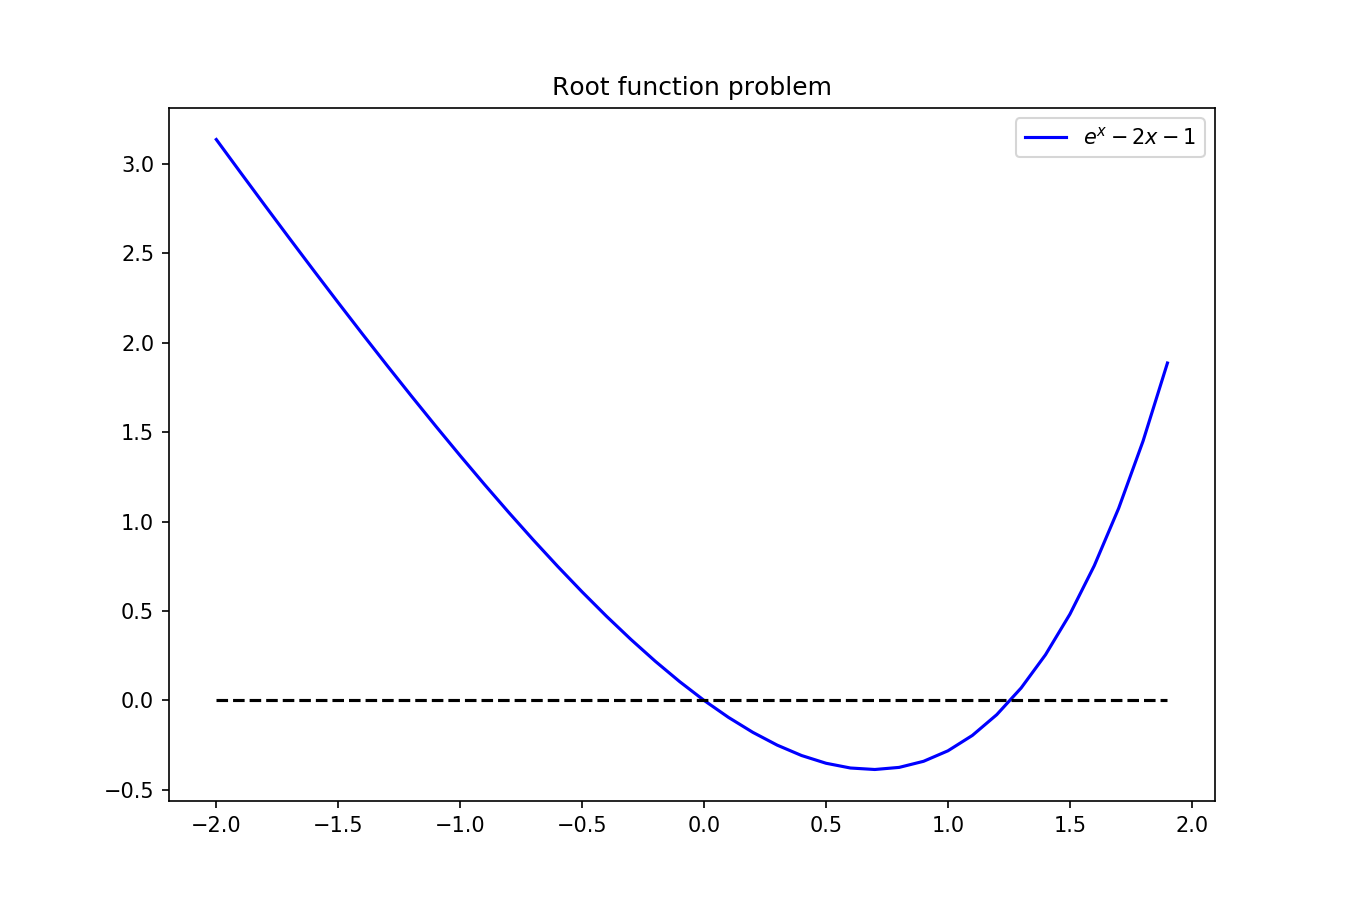

Text(0.5, 1.0, 'Root function problem')

In [55]:
plt.plot(x, root_function(x), 'b', label="$e^x - 2x - 1$")
plt.plot(x, np.zeros(x.size), 'k--')
plt.legend()
plt.title("Root function problem")


As one can see from the plot, $f$ has two roots, let's call them $\tilde{x}_1, \tilde{x}_2$. One of them you can probably guess: $\tilde{x}_1=0$. Let's check analytically:

$$
f(0) = e^0 - 2\cdot 0 -1 = 1 - 1 = 0.
$$

Seems legit. However, the other root, may not be as easy to express as a numerical value (or maybe it is, who knows, but the exercise is to find the root numerically).

We can rewrite the problem (2), in a way that is suited for an iterative procedure. That is, we would like to have a function $g(x)$ such that $g(\tilde{x}_2) = \tilde{x}_2$. We have that:

$$
f(x) = 0 \iff g(x) - x = 0
$$

In this case, $x$ is called a *fixed point$ of $g$.

For instance, we have that

$$
f(x) = 0 \quad \Longrightarrow \quad e^x = 2x + 1 \quad \Longrightarrow \quad x = \ln(2x + 1),
$$
so $g(x) = \ln(2x+1)$.

Let's plot $g(x)$ and $x$ to see what it looks like, and if we can get a sense of why this reformulation would be useful.


<IPython.core.display.Javascript object>


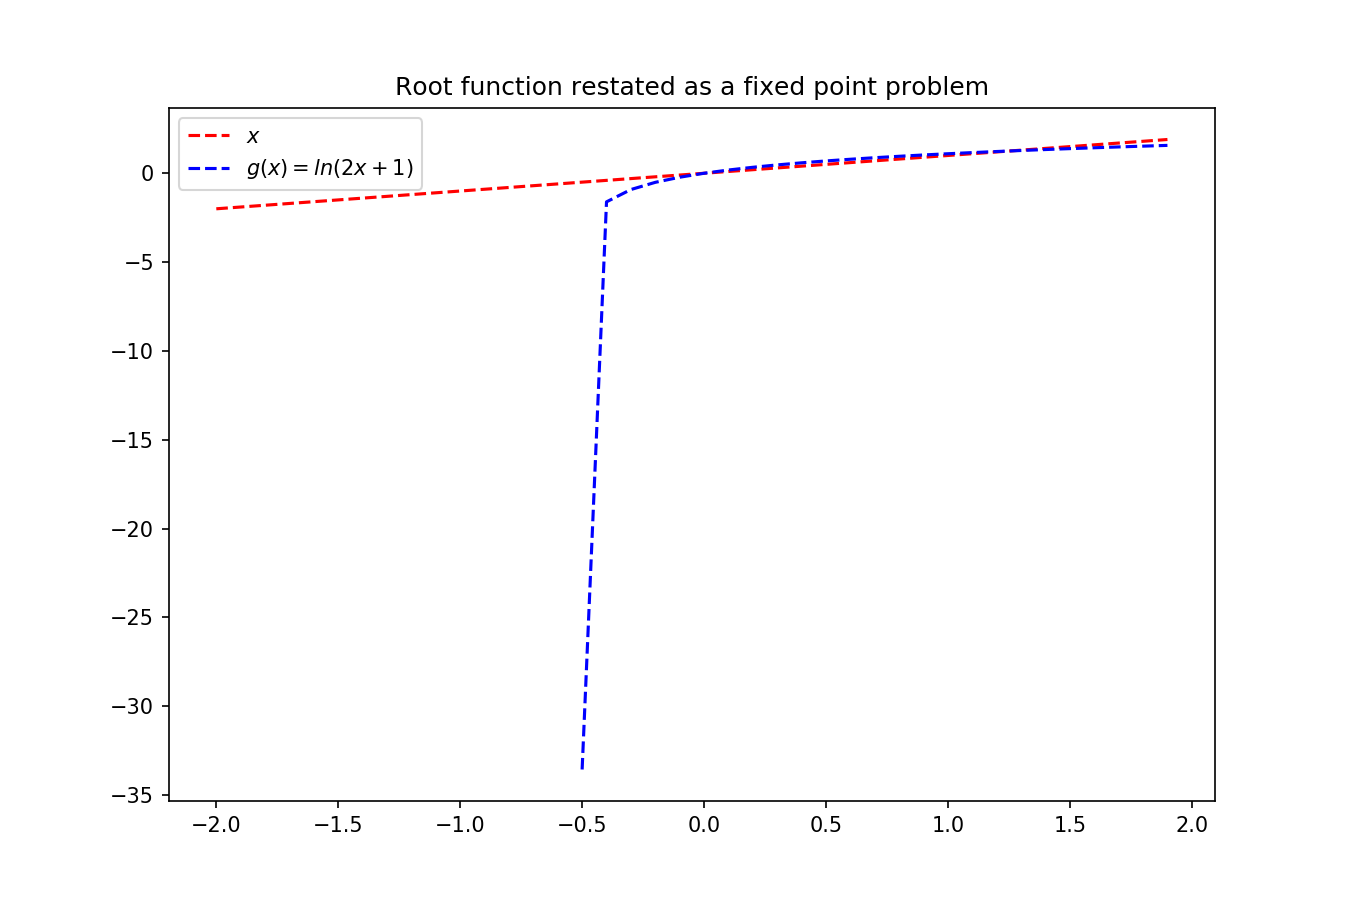

/home/christian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Text(0.5, 1.0, 'Root function restated as a fixed point problem')

In [56]:
# this is a shorhand way of creating an anonymous function, called lambda calculus.
g = lambda x: np.log(2*x+1)
plt.figure()                 # creates a new figure
plt.plot(x, x, 'r--', label='$x$')
plt.plot(x, g(x), 'b--', label='$g(x) = ln(2x+1)$')
plt.legend()
plt.title("Root function restated as a fixed point problem")


Oops... does not look super great! The error message pretty much says that we have fed the **log** function an invalid value. Why is that? Well, as you know $\lim_{x\rightarrow 0^+} = -\infty$, so Python (rightly so) complains when the argument to **log** is less than zero, i.e. $x \leq 0.5$.

In [31]:
np.log(0)

/home/christian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

In [57]:
np.log(1e-16)

-36.841361487904734

Changing the $x$-values so that the argument to **log** is strictly positive should solve the problem.

<IPython.core.display.Javascript object>


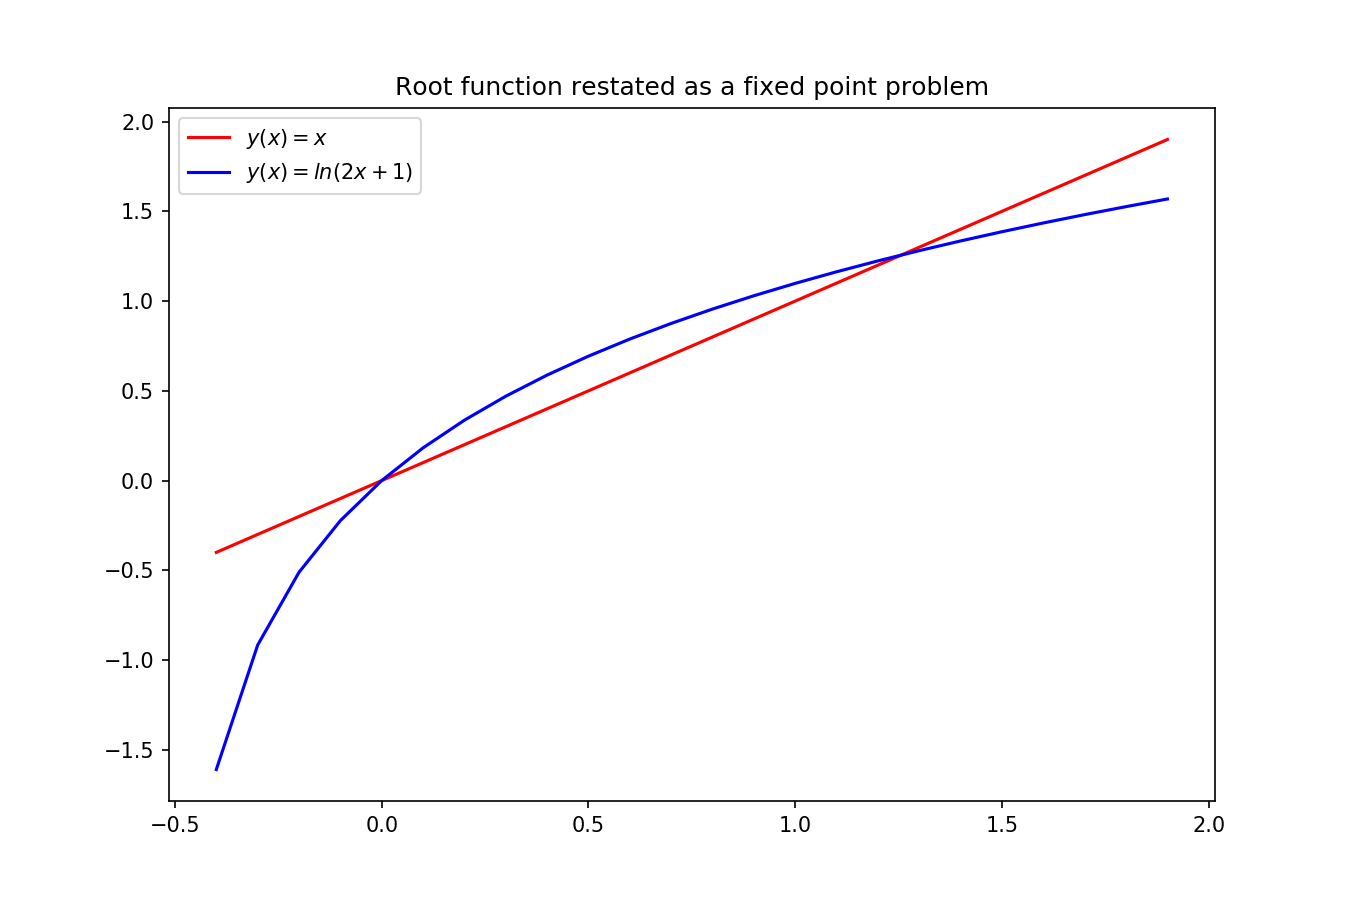

Text(0.5, 1.0, 'Root function restated as a fixed point problem')

In [58]:
x = np.arange(-0.4, 2.0, 0.1)
plt.figure()                 # creates a new figure
plt.plot(x, x, 'r', label='$y(x) = x$')
plt.plot(x, g(x), 'b', label='$y(x) = ln(2x+1)$')
plt.legend()
plt.title("Root function restated as a fixed point problem")

Now the iterative procedure consists of starting with an initial guess for the root, let's call it $x_0$ and from this somehow get a better guess $x_1$. Given the properties of the function $g(x)$, we now that a *good* guess $x_k$ would result in

$$
g(x_k) \approx x_k.
$$

This gives us a hint that we can to get $x_{k+1}$, we can use the formula

$$
g(x_k) = x_{k+1}.
$$

Now we just have to code it up to see if it works. There are two basic approches to this: 
1. The first uses a method that is very familiar to you by now: the loop
2. The second (maybe?) is less intuitive: recursion.

### Loop troop

It is not really necessary to do this as a function, but I do like to be as generic as I can when doing things like this so that it is easy to try things out. The basic idea is, I think, quite intuitive: for each guess, $x_k$ we want to apply $g(x_k)$, store that value as $x_{k+1}$, and then reapply the procedure. In the simplest of worlds, we can do this as a free-standing loop:

In [34]:
iterations = 10 # pick the number of iterations you want to do
x_guess = 2.0   # start with an initial guess
# loop through the iterations
for i in range(iterations):
    x_guess = g(x_guess)
    
print(f"The final guess of the root after {iterations} iterations is {x_guess}")

The final guess of the root after 10 iterations is 1.258238836951012


Super easy. Basically one could do 3 lines of code and be done. The approximate root looks pretty ok too. However, we want to be more generic. The below function takes the inital guess, the $g$ function, and as optional arguments (which have default values), one can specify the number of iterations and the relative tolerance.

In [35]:
def fixed_point_loop(init_guess, g_function, num_iter=10, tol=1e-4, info=True):
    """Finds a root of the function f(x) = g(x) - x = 0
    
    Parameters
    ----------
    init_guess : float
        The initial guess of the root.
    g_function : 
        The fixed point function
    num_iterations : int, optional
        The number of fixed point iterations to take (max).
    tol : float, optional
        Tolerance criterion for when to stop iterations, i.e
        if |x_{k+1} - x_{k}| < tol, the method is deemed to have
        converged

    Returns
    -------
    guesses_array : array
        The guesses of the root, if found. Otherwise, Nan.
    rel_change : float
        The relative change at convergence.
    """
    # [] creates a list, which is a mutable object: it can change its size after initiation.
    # this is so that we can append to the intial guess all subsequent guesses
    guesses_list = [init_guess]
    for i in range(num_iter):
        guesses_list.append(g_function(guesses_list[-1]))
        rel_change = np.abs(guesses_list[-1] - guesses_list[-2])
        if rel_change <= tol:
            # if the tolerance is met, return the values
            # let's also type cast the 'guesses_list' back to an array.
            guesses_array = np.array(guesses_list)
            # print some sort of a info message
            if info:
                print(
                    "The fixed point iterations converged in {} iterations!".format(
                        guesses_array.size))
            return guesses_array, rel_change
    if info:
        print("The fixed point iteration reached its max iterations!")
    guesses_array = np.array(guesses_list)
    return guesses_array, rel_change

As you can see, most of the "code" is a text string (the red part enclosed by """..."""); this is a document string. It is not vital for the function, but I would recommend all of you to try to document your code. After a while I (and most coders I know) tend to forget things. The pro with the above in Python is that one can do:

In [36]:
help(fixed_point_loop)

Help on function fixed_point_loop in module __main__:

fixed_point_loop(init_guess, g_function, num_iter=10, tol=0.0001, info=True)
    Finds a root of the function f(x) = g(x) - x = 0
    
    Parameters
    ----------
    init_guess : float
        The initial guess of the root.
    g_function : 
        The fixed point function
    num_iterations : int, optional
        The number of fixed point iterations to take (max).
    tol : float, optional
        Tolerance criterion for when to stop iterations, i.e
        if |x_{k+1} - x_{k}| < tol, the method is deemed to have
        converged
    
    Returns
    -------
    guesses_array : array
        The guesses of the root, if found. Otherwise, Nan.
    rel_change : float
        The relative change at convergence.



## Recursive approach

Thinking about the above, we can express the iterative algorithm as

\begin{align}
x_1 &= g(x_0)\\
x_2 &= g(x_1) = g(g(x_0))\\
&\;\vdots\\
x_k &= g^k(x_0)
\end{align}

Now, this can be implemented by a function that, given some criteria, calls itself. Basically we want a function that takes similar arguments as **fixed_point_loop**, but if neither the (max) number of iterations or the tolerance is fulfilled, it continues the iteration by calling itself. Such a function is called a recursive function. I include an attempt at this here mostly for informative reasons, and for the curious student. 

*Note: this is probably not the greatest example of when to use this but illustrates the concept. There are, however, situations when recursive functions greatly reduce the amount of code without increasing complexity*.

In [37]:
def fixed_point_recursive(x, g_function, num_iter=10, tol=1e-4,
                         first_iteration=True, info=False):
    """Finds a root of the function f(x) = g(x) - x = 0
 
    Parameters
    ----------
    x : float
        Initial guess of the root.
    g_function : 
        The fixed point function
    num_iter : int, optional
        How many fixed point iterations to go.
    tol : float, optional
        Tolerance criterion for when to stop iterations, i.e
        if |x_{k+1} - x_{k}| < tol, the method is deemed to have
        converged
    first_iteration :
        True if first call to functin, False for all recursive calls.
        Default is True.
    Returns
    -------
    guesses_array : array
        The guesses of the root, if found. Otherwise, Nan.
    rel_change : float
        The relative change at convergence.
    """
    # if the first time the function is called, create a local
    # variable to which we can append the guesses
    if first_iteration:
        # creates a attribute (variable bound to the function) that
        # therefore can be accessed by all recursive function calls
        fixed_point_recursive.guesses_list = [x]
    # get next guess
    x_k = g_function(x)
    # decrease the number of iteration
    num_iter -= 1
    fixed_point_recursive.guesses_list.append(x_k)
    # check tolerance
    rel_change = np.abs((x_k - x) / x)
    if rel_change <= tol or num_iter == 0:
        guesses_array = np.array(fixed_point_recursive.guesses_list)
        if num_iter == 0 and info:
            print("The fixed point iteration reached its max iterations!")
        elif info:
            print("The fixed point iterations converged in {} iterations!".format(
                guesses_array.size))
        else:
            pass
        return guesses_array, rel_change
    else:
        fixed_point_recursive.guesses_list, rel_change = fixed_point_recursive(
            x_k, g_function, num_iter, tol=tol, first_iteration=False)
        return fixed_point_recursive.guesses_list, rel_change


## Solution procedure

We will use the loop function here to try with an initial guess $x = 2.0$

In [38]:
guesses, change = fixed_point_loop(2.0, g)
print("The relative change of the last iterations is: {:.3e}".format(change))
print("The guesses for the root are:")
print_string = "{:.3f} "*guesses.size
print(print_string.format(*guesses))

The fixed point iteration reached its max iterations!
The relative change of the last iterations is: 1.370e-03
The guesses for the root are:
2.000 1.609 1.440 1.356 1.311 1.287 1.274 1.266 1.262 1.260 1.258 


We can now check if our solution is good by doing:

In [39]:
print("f({:.3e}) = {:.3e}".format(guesses[-1], root_function(guesses[-1])))

f(1.258e+00) = 2.740e-03


What the above two cells tell us is that we used all of our iterations ($10$) and did not meet the default tolerance for the relative change ($10e^-4$), and that we are fairly close to the root. Let's try to improve that, by adding more iteration, and possibly changing the tolerance.

In [40]:
guesses, change = fixed_point_loop(2.0, g, num_iter=1000, tol=10e-6)
print("The relative change of the last iterations is: {:.3e}".format(change))
print("The guesses for the root are:")
print_string = "{:.3f} "*guesses.size
print(print_string.format(*guesses))
print("f({:.3e}) = {:.3e}".format(guesses[-1], root_function(guesses[-1])))

The fixed point iterations converged in 20 iterations!
The relative change of the last iterations is: 8.584e-06
The guesses for the root are:
2.000 1.609 1.440 1.356 1.311 1.287 1.274 1.266 1.262 1.260 1.258 1.257 1.257 1.257 1.257 1.257 1.256 1.256 1.256 1.256 
f(1.256e+00) = 1.717e-05


The reason why I have chosen to return all the guesses $x_k$, is so that we can plot and see geometrically what is going on. To do this we need to create a couple of new vectors for the plotting; a suitable way would be to plot the points $[(x_0, x_0), (x_0, g(x_0)), (x_1, x_1), (x_1, g(x_1))\dots (x_k, g(x_k))]$, so we need a plotting $x$-vector containing $[x_0, x_1, \dots, x_k]$ and a $y$-vector $[x_0, g(x_0), g(x_0),\dots,g(x_k)]$.

<IPython.core.display.Javascript object>


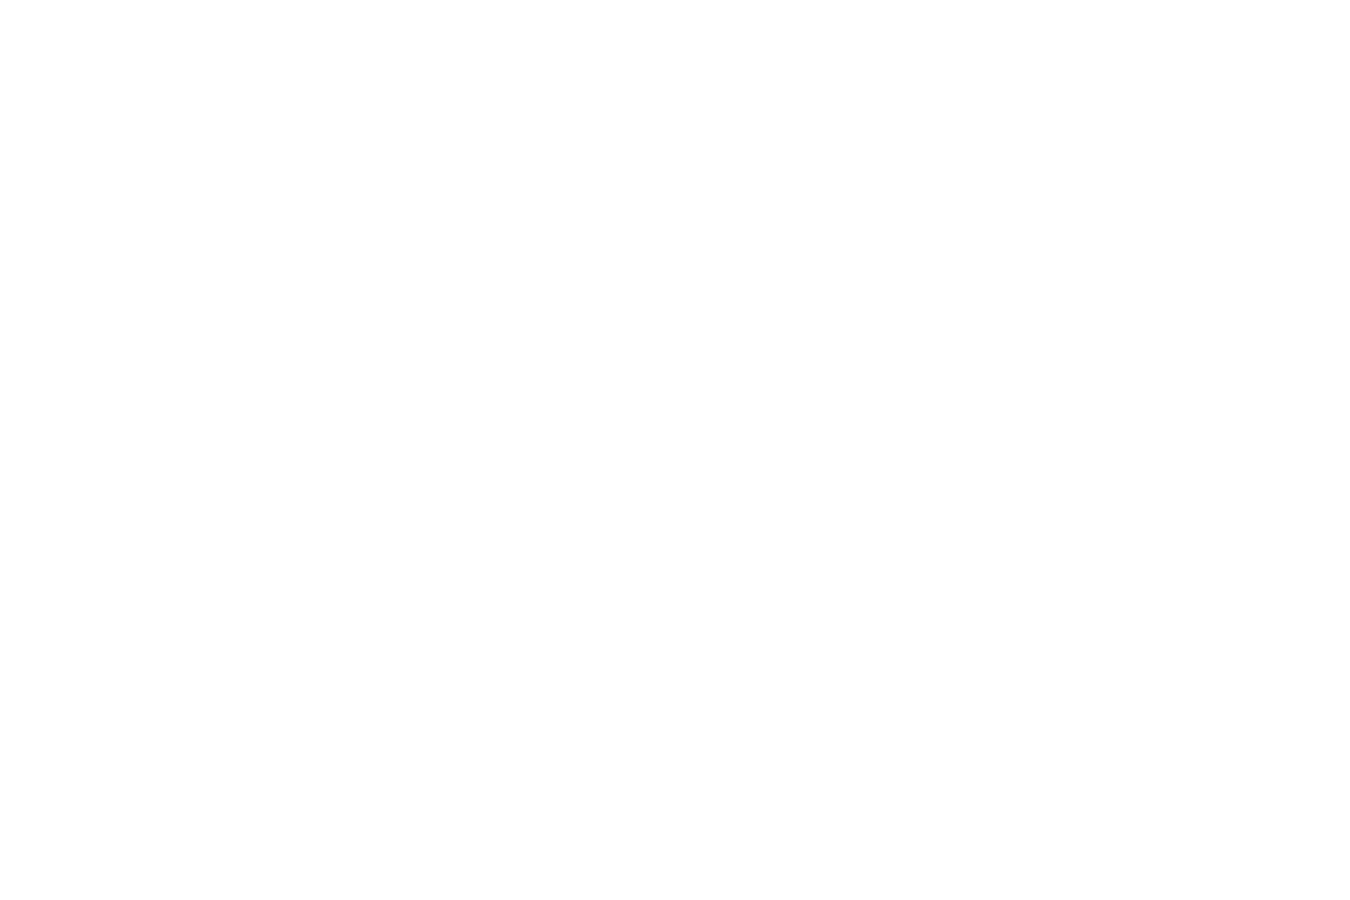

Text(0.5, 1.0, 'Fixed point iterations')

In [41]:
x_plot = [i for j in range(len(guesses)-1) for i in [guesses[j]]*2]
y_plot = [i for j in range(len(guesses)-1) for i in guesses[j:j+2]]
plt.figure()                 # creates a new figure
plt.plot(x, x, 'r-', label='$y(x)=x$')
plt.plot(x, g(x), 'b-', label='$y(x) = ln(2x+1)$')
plt.plot(x_plot, y_plot, 'k--', label="Iterations", lw=1.5)
plt.plot(x_plot[0], y_plot[0], 'cp', ms=10, label="Init guess")
plt.legend()
plt.grid()
plt.title("Fixed point iterations")


Try another guess and plot the same thing...

The fixed point iterations converged in 36 iterations!


<IPython.core.display.Javascript object>


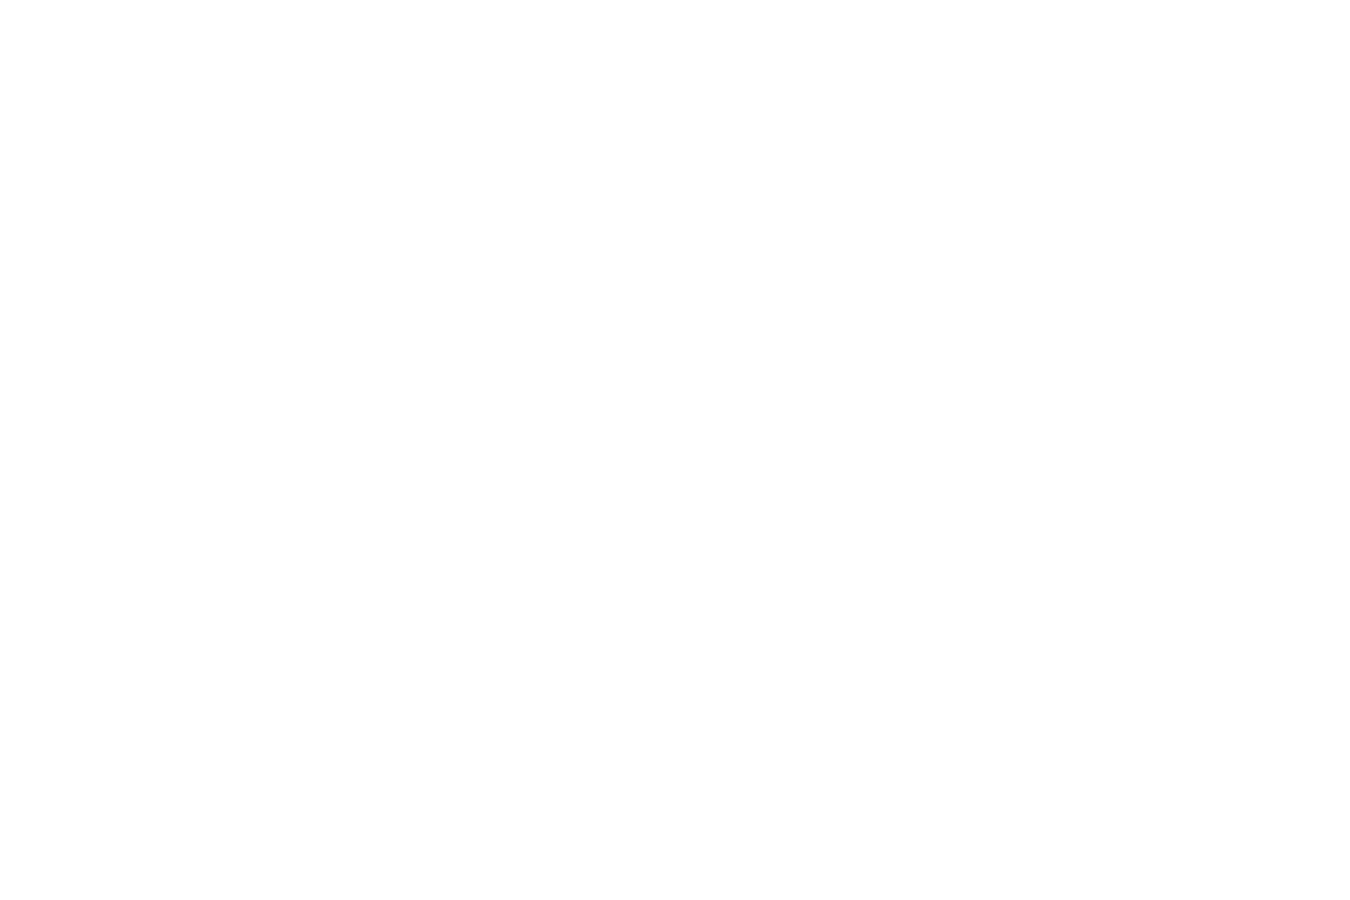

Text(0.5, 1.0, 'Fixed point iterations')

In [42]:
init_guess = 1e-4
guesses, change = fixed_point_loop(init_guess, g, num_iter=1000, tol=10e-6)
x_plot = [i for j in range(len(guesses)-1) for i in [guesses[j]]*2]
y_plot = [i for j in range(len(guesses)-1) for i in guesses[j:j+2]]
plt.figure()                 # creates a new figure
plt.plot(x, x, 'r-', label='$y(x)=x$')
plt.plot(x, g(x), 'b-', label='$y(x) = ln(2x+1)$')
plt.plot(x_plot, y_plot, 'k--', label="Iterations", lw=1.5)
plt.plot(x_plot[0], y_plot[0], 'cp', ms=10, label="Init guess")
plt.legend()
plt.grid()
plt.title("Fixed point iterations")

This is interesting; even if our initial guess was really close to our *analytically determined* root, $\tilde{x}_1$, the fixed point algorithm that we used found the same root $\tilde{x}_2 \approx 1.265$. Why would this be? Let's make a final test with an initial guess on the left hand side of $\tilde{x}_1$.

The fixed point iteration reached its max iterations!


/home/christian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


<IPython.core.display.Javascript object>


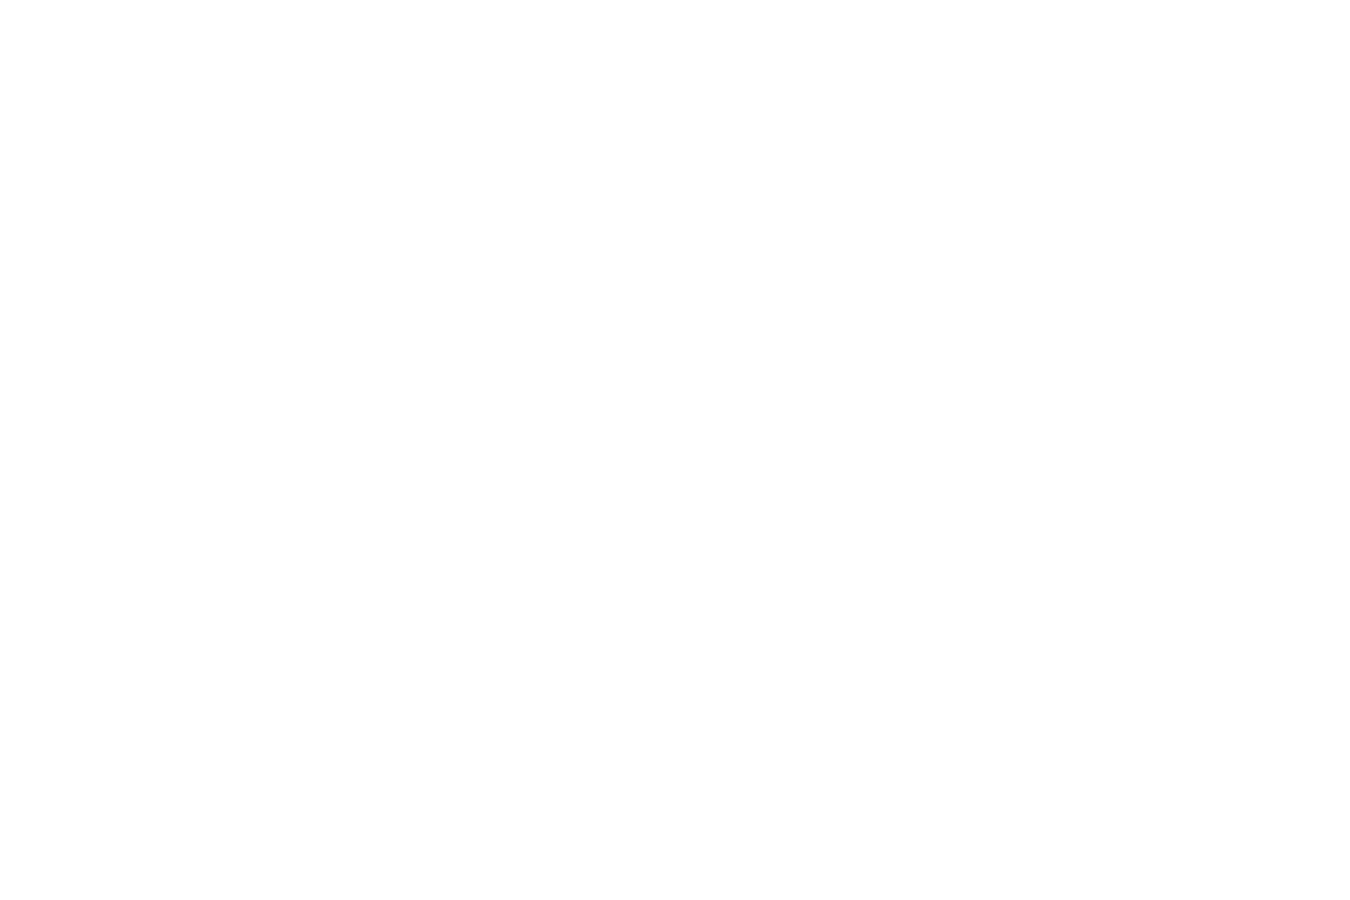

nan

In [43]:
init_guess = -1e-5
guesses, change = fixed_point_loop(init_guess, g, num_iter=1000, tol=10e-6)
x_plot = [i for j in range(len(guesses)-1) for i in [guesses[j]]*2]
y_plot = [i for j in range(len(guesses)-1) for i in guesses[j:j+2]]
plt.figure()                 # creates a new figure
plt.plot(x, x, 'r-', label='$y(x)=x$')
plt.plot(x, g(x), 'b-', label='$y(x) = ln(2x+1)$')
plt.plot(x_plot, y_plot, 'k--', label="Iterations", lw=1.5)
plt.plot(x_plot[0], y_plot[0], 'cp', ms=10, label="Init guess")
plt.legend()
plt.grid()
plt.title("Fixed point iterations")
change

Two questions may pop up when you think about this:
1. How do we find (numerically) the root $\tilde{x}_1$, given that the above diverges?
2. *Why* does it diverge?

### How to find the second root

When we found a function $g$ for the problem (2), we chose the first best one. This does *not* mean that $g$ is the unique function to fulfill the condition to have a root of $f$ being a fixed point. In fact, checking (since we know the the value of the root) if  $\tilde{x}_1$ is a fixed point of $g$ we see that

$$
g(\tilde{x}_1) = \ln(2\cdot 0 + 1) = \ln(1) = 0 = \tilde{x}_1
$$
it is. 

<span style="color:red">*Note: if you would attempt to use $0$ as an initial guess for the argument of **fixed_point_loop**, you would encounter an error. Can you find where this is in the code? Try to fix the function so that it gives the right result in this case, i.e. "convergence" if you start with $x_0 = 0$. </span>

Investigating, we can see that multiple options for a critical point function exist
$$
f(x) = 0 \iff \ln(2x+1) = x \iff \frac{e^x -1}{2} = x,
$$
we could even choose
$$
g(x) = x(e^x - 2x).
$$
Lets plot the functions for comparison and see if there is some sort of a geometrical argument that can help us determine what function to choose.

<IPython.core.display.Javascript object>


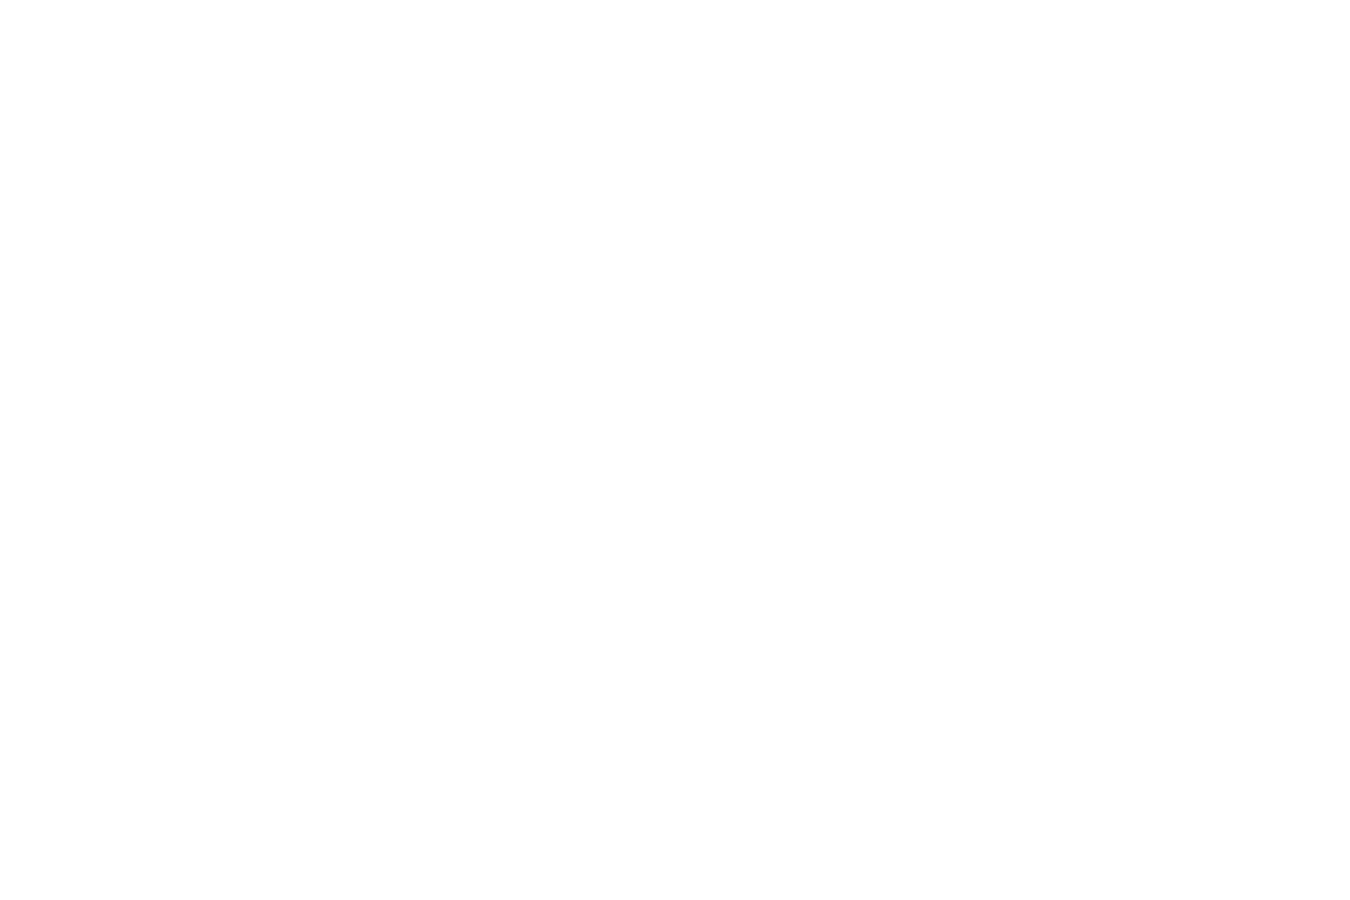

Text(0.5, 0.98, 'Critical point functions')

In [44]:
g1 = lambda x: (np.e**x - 1)/2
g2 = lambda x: x*(np.e**x - 2*x)
plt.figure()
plt.subplot(1,3,1)
plt.plot(x, g(x), 'b', label="$y(x) = \ln(2x+1)$")
plt.plot(x, x, 'k--', label="$y(x)=x$", lw=1.5)
plt.legend()
plt.subplot(1,3,2)
plt.plot(x, g1(x), 'b', label="$y(x) = (e^x - 1)/2$")
plt.plot(x, x, 'k--', label="$y(x)=x$", lw=1.5)
plt.legend()
plt.subplot(1,3,3)
plt.plot(x, g2(x), 'b', label="$y(x) = x(e^x - 2x)$")
plt.plot(x, x, 'k--', label="$y(x)=x$", lw=1.5)
plt.legend()
plt.suptitle("Critical point functions")

The pragmatic approach here would be to just choose one of the other two functions and see what happens. We can of course do that quite easily, since we have a function and all we need is an initial guess and change the argument to **fixed_point_iteration** to be $g_1(x) = \frac{e^x -1}{2}$, for instance.

The fixed point iterations converged in 17 iterations!


<IPython.core.display.Javascript object>


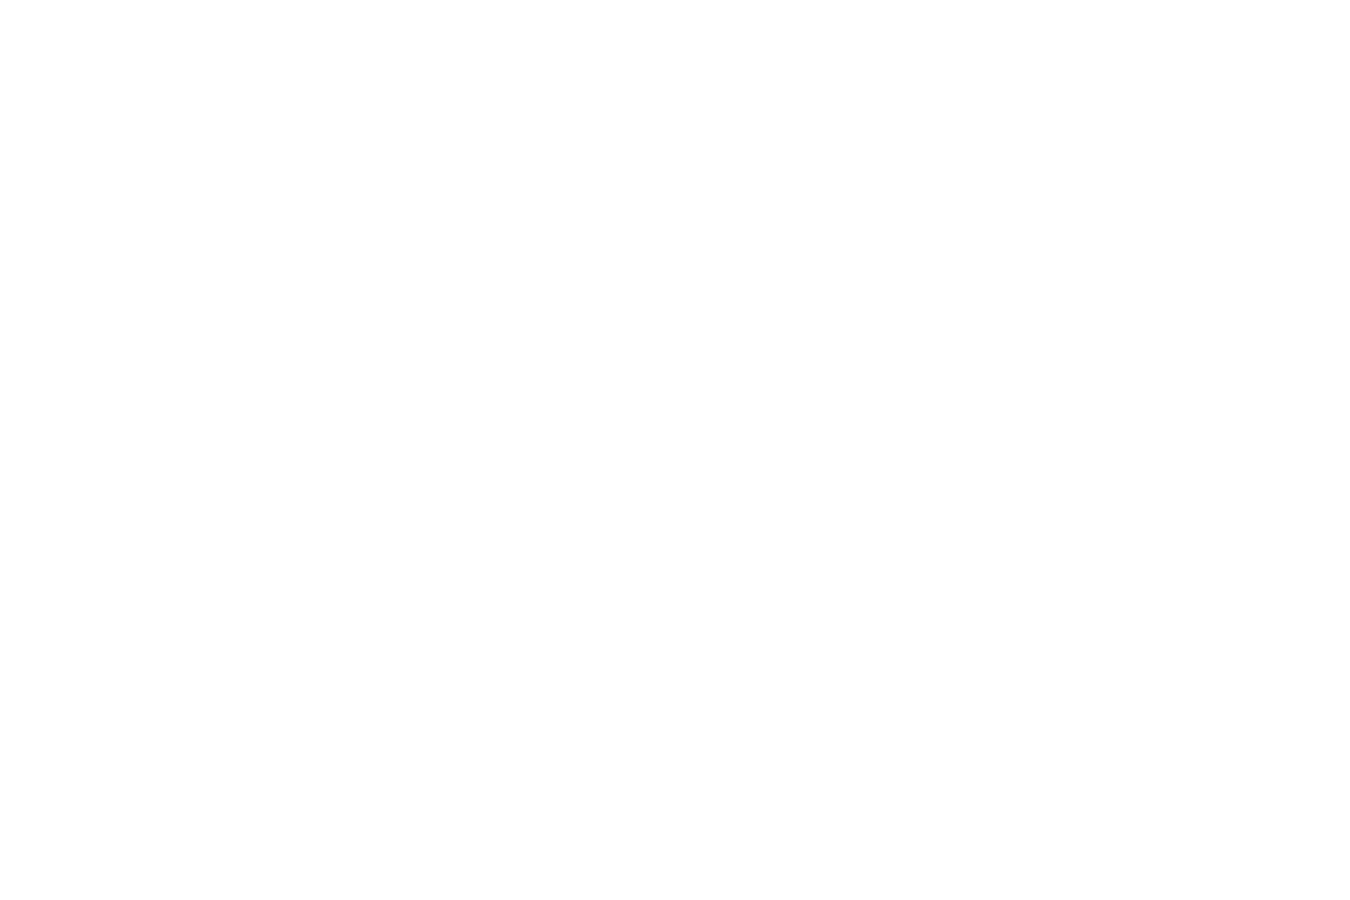

Text(0.5, 1.0, 'Fixed point iterations for $g_1$')

In [45]:
init_guess = -4
guesses, change = fixed_point_loop(init_guess, g1, num_iter=1000, tol=10e-6)
x_plot = [i for j in range(len(guesses)-1) for i in [guesses[j]]*2]
y_plot = [i for j in range(len(guesses)-1) for i in guesses[j:j+2]]
plt.figure()                 # creates a new figure
# change the x values for plotting, since new function
x = np.arange(-5, 2, 0.1)
plt.plot(x, x, 'r-', label='$y(x)=x$')
plt.plot(x, g1(x), 'b-', label='$y(x) = (e^x - 1)/2$')
plt.plot(x_plot, y_plot, 'k--', label="Iterations", lw=1.5)
plt.plot(x_plot[0], y_plot[0], 'cp', ms=10, label="Init guess")
plt.legend()
plt.grid()
plt.title("Fixed point iterations for $g_1$")

### Why do different critical point functions diverge?
By now, you probably have a good guess of why this is the case, at least from an intuitive and geometric point of view. The plot to the left is the function $g$ that we have been using so far. We *numerically* established that thefor $\lim_{k\rightarrow \infty} x_k = \tilde{x}_2$ to hold, the valid interval for an initial guess was $x_0\in(0, \infty)$. However, looking at the plot, we can see that
$$
g(x)\in (0, \infty) \quad \forall x\in(0, \infty).
$$
By now, we don't need to run our functions to see if it is going to converge or not, we have the pattern sketched out in the various plots above. Similarly to $g$ we can see that
$$
g_1(x)\in (-\infty, \tilde{x}_2) \quad \forall x\in(-\infty, \tilde{x}_2)\\
$$

That is, $g,g_1$ maps the domains into themselves. Importantly $\tilde{x}_2\in(0,\infty)$ (image of $g$) and $\tilde{x}_1\in (-\infty, \tilde{x}_2)$ (image of $g_1$).

You can think about what this is in the third scenario, $g_2$.

Actually (bit too much to go through here), there is a theorem (the [*Contraction mapping theorem*](https://en.wikipedia.org/wiki/Banach_fixed-point_theorem "Contraction mapping theorem")), that guarantees the success of a fixed point algorithm. In our case, the theorem means that if we have a function $g$ that is continuous and fulfills $g(x)\in[a,b]$ and $g^{\prime}(x) < 1 \forall x\in[a,b]$, then
* $g$ has a *uniqe* fixed point in $[a,b]$ and
* the iterative procedure $x_k = g(x_{k-1})$ converges to the uniqe fixed point.





## Some timing experiments for fun

In [46]:
%%timeit
guesses, change = fixed_point_loop(100, g, num_iter=1000, tol=10e-6, info=False)

90.4 µs ± 6.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [47]:
%%timeit
guesses, change = fixed_point_recursive(100, g, num_iter=1000, tol=10e-6, info=False)

95.3 µs ± 4.84 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [48]:
%%timeit
x_guess = 100
tol = 10e-6
while True:
    x_next = np.log(2*x_guess + 1)
    if np.abs(x_next-x_guess) < tol:
        break
    x_guess = x_next


70.5 µs ± 3.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Compare this to the more specialized functions in the *Scientific Python* library/package:

In [49]:
from scipy import optimize

**SciPy** is mostly written in C, which makes low level operations behind the hood really fast. Let's use the same method (bisection method). We need to provide the interval $[a,b]$, discussed above, that one thinks contains the root. We choose the far end of the interval to be the same as the inital guess above: $(0.5, 1000)$.

In [50]:
%%timeit
scipy_root = scipy.optimize.bisect(root_function, 0.5, 100)

NameError: name 'scipy' is not defined

Performance wise this pretty much demolishes our naive implementation.

## References

The basis for this notebook is Chapter 1 from the book [An introduction to Numerical Analysis by Süli and Mayers](https://www.cambridge.org/gb/academic/subjects/mathematics/numerical-analysis/introduction-numerical-analysis-1?format=PB)